In [0]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -rv "/content/drive/My Drive/datasets/dncnn_dataset/" "/content/"

'/content/drive/My Drive/datasets/dncnn_dataset/' -> '/content/dncnn_dataset'
'/content/drive/My Drive/datasets/dncnn_dataset/test' -> '/content/dncnn_dataset/test'
'/content/drive/My Drive/datasets/dncnn_dataset/test/Set12' -> '/content/dncnn_dataset/test/Set12'
'/content/drive/My Drive/datasets/dncnn_dataset/test/Set12/10.png' -> '/content/dncnn_dataset/test/Set12/10.png'
'/content/drive/My Drive/datasets/dncnn_dataset/test/Set12/07.png' -> '/content/dncnn_dataset/test/Set12/07.png'
'/content/drive/My Drive/datasets/dncnn_dataset/test/Set12/02.png' -> '/content/dncnn_dataset/test/Set12/02.png'
'/content/drive/My Drive/datasets/dncnn_dataset/test/Set12/03.png' -> '/content/dncnn_dataset/test/Set12/03.png'
'/content/drive/My Drive/datasets/dncnn_dataset/test/Set12/06.png' -> '/content/dncnn_dataset/test/Set12/06.png'
'/content/drive/My Drive/datasets/dncnn_dataset/test/Set12/11.png' -> '/content/dncnn_dataset/test/Set12/11.png'
'/content/drive/My Drive/datasets/dncnn_dataset/test/Set12

In [0]:
import torch as tor
import torch.nn as nn
import torch.utils.data
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

from skimage.measure import compare_ssim as ssim

In [0]:
def calc_total_mean(datafiles,num_chn = 3,verbose = False):

    img_sum = 0
    num_files = len(datafiles)

    for e,file in enumerate(datafiles):

        if(num_chn == 3):
            img = cv2.resize(cv2.imread(file),(256,256))
            img_sum += img
        elif(num_chn == 1):
            img = cv2.imread(file,0)
            img_sum += img
        else:
            assert "Incorrect number of channels"

        if(verbose):
            print(e,file)


    return np.float32(img_sum) / num_files

In [0]:
class dncnn(nn.Module):

    def __init__(self,in_channels = 3,depth = 17):

        super().__init__()

        layers = []

        layers.append(nn.Conv2d(in_channels = in_channels,out_channels = 64,kernel_size = (3,3),padding = 1))
        layers.append(nn.ReLU(inplace = True))

        for l in range(depth - 2):
            layers.append(nn.Conv2d(in_channels = 64,out_channels = 64,kernel_size = (3,3),padding = 1))
            layers.append(nn.ReLU(inplace = True))
            layers.append(nn.BatchNorm2d(64))

        layers.append(nn.Conv2d(in_channels = 64,out_channels = in_channels,kernel_size = (3,3),padding = 1))

        self.net = nn.Sequential(*layers)

        self.init_weights()

    def forward(self,y):

        out = self.net(y)
        return y - out

    def init_weights(self):

        for m in self.modules():

            if(isinstance(m,nn.Conv2d)):
                nn.init.orthogonal_(m.weight)

                if(m.bias is not None):
                    nn.init.constant_(m.bias,0)

            elif(isinstance(m,nn.BatchNorm2d)):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)

In [0]:
def getpatch(img,patchsize):

    h,w,_ = img.shape
    x,y = np.random.randint(0,w - patchsize),np.random.randint(0,h - patchsize)

    patch = img[y:y + patchsize,x:x + patchsize,:]

    return patch

In [0]:
class dataset(torch.utils.data.Dataset):

    total_mean = 0.0

    def __init__(self,data_dir,data_size = -1,patchsize = 40,sigma = 25,phase = "",apply_transform = False):

        super().__init__()

        self.datafiles = os.listdir(data_dir)
        self.datafiles = [os.path.join(data_dir,x) for x in self.datafiles]

        if(data_size == -1):
            self.data_size = len(self.datafiles)

        if(phase == "train"):
            dataset.total_mean = tor.from_numpy(calc_total_mean(self.data_files))
            dataset.total_mean = dataset.total_mean.permute(2,0,1)

        self.patchsize = patchsize
        self.sigma = sigma

    def __len__(self):
        return self.data_size

    def __getitem__(self,idx):

        imgname = self.datafiles[idx]
        img = np.float32(cv2.imread(imgname,1))
        clean_patch = getpatch(img,self.patchsize)
        clean_patch = tor.from_numpy(clean_patch).permute(2,0,1)

        noise = tor.randn(clean_patch.size()).mul_(self.sigma)

        noisy_patch = clean_patch + noise

        return noisy_patch,clean_patch

In [0]:
def train(net,epochs,dataloaders,hyper_params,reset = True,save = False):

    if(reset):
        net.init_weights()
        print("/////////////// Weights Reset \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\")

    trainloader,valloader = dataloaders

    lr,reg = hyper_params

    optimizer = tor.optim.Adam(net.parameters(),lr = lr,weight_decay = reg)
    criterion = nn.MSELoss()

    for epoch in range(epochs):

        batch_losses = []

        for batch_idx,(noisy_patch,clean_patch) in enumerate(trainloader):

            noisy_patch,clean_patch = noisy_patch.to(device),clean_patch.to(device)

            optimizer.zero_grad()

            out = net(noisy_patch)
            loss = criterion(out,clean_patch)
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

        print("Epoch: ",epoch,"train loss: ",np.mean(batch_losses))

        net.eval()
        with tor.no_grad():
            
            batch_losses = []
            
            for batch_idx,(valdata,vallabel) in enumerate(valloader):

                valdata,vallabel = valdata.to(device),vallabel.to(device)

                valout = net(valdata)
                loss = criterion(valout,vallabel)

                batch_losses.append(loss.item())

            print("Val Loss: ",np.mean(batch_losses))
    

        print("-------------------------------------------------------------------------")
        net.train()

In [0]:
traindir = "./dncnn_dataset/train/"
trainset = dataset(traindir)
trainloader = torch.utils.data.DataLoader(trainset,batch_size = 32,shuffle = True)

In [0]:
valdir = "./dncnn_dataset/val/"
valset = dataset(valdir)
valloader = torch.utils.data.DataLoader(valset,batch_size = 32,shuffle = True)

In [0]:
device = tor.device("cuda:0" if tor.cuda.is_available() else "cpu")
net = dncnn().to(device)

In [0]:
state = tor.load("/content/drive/My Drive/datasets/dncnn_dataset/dncnn_chk.pth.tar")
net.load_state_dict(state)

<All keys matched successfully>

In [0]:
epochs = 200
lr = 1e-3
reg = 0.0
reset = True
hyper_params = [lr,reg]

dataloaders = [trainloader,valloader]

train(net,epochs,dataloaders,hyper_params,reset = reset)

/////////////// Weights Reset \\\\\\\\\\\\\\\\\
Epoch:  0 train loss:  609.8104060246394
Val Loss:  600.57275390625
-------------------------------------------------------------------------
Epoch:  1 train loss:  538.4575007512019
Val Loss:  484.81068420410156
-------------------------------------------------------------------------
Epoch:  2 train loss:  474.91966130183295
Val Loss:  418.3551940917969
-------------------------------------------------------------------------
Epoch:  3 train loss:  418.5677889310397
Val Loss:  365.9681701660156
-------------------------------------------------------------------------
Epoch:  4 train loss:  364.091794527494
Val Loss:  314.2250671386719
-------------------------------------------------------------------------
Epoch:  5 train loss:  305.2370042067308
Val Loss:  256.59986114501953
-------------------------------------------------------------------------
Epoch:  6 train loss:  259.00711529071515
Val Loss:  238.02416229248047
----------------

In [0]:
testdir = "./dncnn_dataset/test/Set12/"
testset = dataset(valdir)
testloader = torch.utils.data.DataLoader(testset,batch_size = 32,shuffle = True)

In [0]:
criterion = nn.MSELoss()

net.eval()
with tor.no_grad():
    
    batch_losses = []
    
    for batch_idx,(testdata,testlabel) in enumerate(testloader):

        testdata,testlabel = testdata.to(device),testlabel.to(device)

        testout = net(testdata)
        loss = criterion(testout,testlabel)

        batch_losses.append(loss.item())

    print("Test Loss: ",np.mean(batch_losses))


print("-------------------------------------------------------------------------")
_ = net.train()

Test Loss:  61.98724174499512
-------------------------------------------------------------------------


In [0]:
state = net.state_dict()

tor.save(state,"/content/drive/My Drive/datasets/dncnn_dataset/dncnn_chk.pth.tar")

In [0]:
def psnr(img1, img2,PIXEL_MAX):
    """
        Calculates the peak signal-to-noise ratio of 2 images
        
        Arguments:
            img1: Image1
            img2: Image2
            
        Returns:
            The peak signal-to-noise ratio of the 2 images
    """
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

input psnr:  13.78319166116594
input ssim:  0.4938559230579102


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


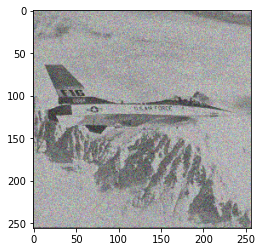

In [0]:
sigma = 35

img = np.float32(cv2.imread("./dncnn_dataset/test/Set12/06.png")) 
img = tor.from_numpy(img)

noise = tor.randn(img.size()).mul_(sigma)

noisy_img = img + noise

noisy_img_n = noisy_img.numpy()

noisy_img1 = ((noisy_img_n - noisy_img_n.min()) / (noisy_img_n.max() - noisy_img_n.min()))
img1 = img.detach().clone().cpu().numpy()
img1 = ((img1 - img1.min()) / (img1.max() - img1.min()))

print("input psnr: ",psnr(noisy_img1,img1,1.0))
print("input ssim: ",ssim(noisy_img1,img1,multichannel = True))

plt.imshow(noisy_img1)

psnr:  18.889291564704767
ssim:  0.77126492196548


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  


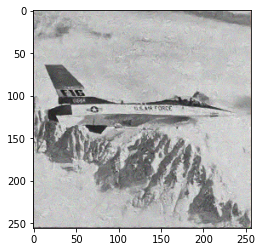

In [0]:
h,w,_ = noisy_img.size()
noisy_img = noisy_img.permute(2,0,1).unsqueeze(0).to(device)

res = net(noisy_img)
clean_img = res.squeeze().permute(1,2,0)
clean_img = clean_img.detach().clone().cpu().numpy()

# img1 = img.detach().clone().cpu().numpy()

clean_img1 = (clean_img - clean_img.min()) / (clean_img.max() - clean_img.min())
# img1 = (img1 - img1.min()) / (img1.max() - img1.min())

print("psnr: ",psnr(clean_img1,img1,1.0))
print("ssim: ",ssim(clean_img1,img1,multichannel = True))

plt.imshow(clean_img1)